In [2]:
# !pip install -q pydicom
# from google.colab import drive
# drive.mount('/content/drive')


##IMPORTS##
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle

# import plaidml.keras
# plaidml.keras.install_backend()

import tensorflow as tf
from tensorflow.python.keras import backend
import keras
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.layers import GlobalAveragePooling2D, Dense
from keras.layers.core import Dropout, Activation
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.initializers import TruncatedNormal
from keras.regularizers import l1, l2

from keras.applications import InceptionV3
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
# from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import preprocess_input
# from keras_preprocessing.image import ImageDataGenerator

import pydicom
# from pydicom.data import get_testdata_files

from keras.applications.vgg16 import VGG16

## Need for rescaling pixel sizes

(224, 224)


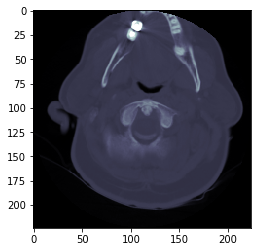

In [3]:
## single gray image
ds = pydicom.dcmread('./input-data/tozip/ID_00005679d.dcm')
img = ds.pixel_array
image_single = cv2.resize(img, dsize=(224, 224))
# Rescaling grey scale between 0-255
image_2d_scaled = (np.maximum(image_single,0) / image_single.max()) * 255.0

# Convert to uint
image_2d_scaled = np.uint8(image_2d_scaled)
# plt.imshow(image_2d_scaled, cmap='gray') 

print(image_2d_scaled.shape)
plt.imshow(image_2d_scaled, cmap=plt.cm.bone) 

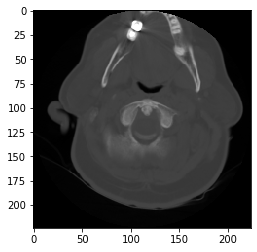

In [4]:
ds = pydicom.dcmread('./input-data/tozip/ID_00005679d.dcm')
image_single = ds.pixel_array
image_single = cv2.resize(image_single, dsize=(224, 224))
#                 image_single = cv2.merge((image_single,image_single,image_single))
# Rescaling grey scale between 0-255
image_single = (np.maximum(image_single,0) / image_single.max()) * 255.0

# Convert to uint
image_single = np.uint8(image_single)
# plt.imshow(image_2d_scaled, cmap='gray') 

image = np.stack([image_single, image_single, image_single])
image = np.moveaxis(image, 0, 2)
plt.imshow(image, cmap='gray') 

## Without rescaling 3 channel image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


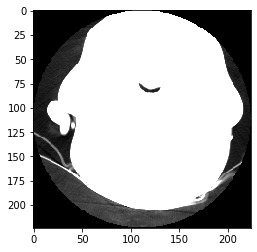

In [5]:
ds = pydicom.dcmread('./input-data/tozip/ID_00005679d.dcm')
image_single = ds.pixel_array
image_single = cv2.resize(image_single, dsize=(224, 224))
#                 image_single = cv2.merge((image_single,image_single,image_single))
# Rescaling grey scale between 0-255
# image_single = (np.maximum(image_single,0) / image_single.max()) * 255.0

# # Convert to uint
# image_single = np.uint8(image_single)
# # plt.imshow(image_2d_scaled, cmap='gray') 

image = np.stack([image_single, image_single, image_single])
image = np.moveaxis(image, 0, 2)
plt.imshow(image, cmap='gray') 

In [1]:
##PATHS##
full_labels_filepath = "input-data/RSNA_training_processed.csv"
# full_data_filepath = "input-data/stage_1_train_images/"
sample_labels_filepath = "input-data/RSNA_sample_labels.csv"
sample_data_filepath = "input-data/tozip/"

##PARAMETERS##
COLUMN = 1

##START##

# Read in labels
full_labels = pd.read_csv(full_labels_filepath)
# print(full_labels.shape)
sample_labels = pd.read_csv(sample_labels_filepath)
# print(sample_labels.shape)
splitdf_index1 = round(0.8 * len(sample_labels))
# print(splitdf_index1)

train_df = sample_labels[ : splitdf_index1]
validate_df = sample_labels[splitdf_index1 : ]

train_list = train_df[train_df.columns[0]].tolist()
validate_list = validate_df[validate_df.columns[0]].tolist()
train_label_list = train_df[train_df.columns[COLUMN]].tolist()
validate_label_list = validate_df[validate_df.columns[COLUMN]].tolist()


def myGenerator(image_lines, label_lines, batch_size):
    num_samples = len(image_lines)
    X_return = []
    y_return = []
    
    while True:
        for offset in range(0, num_samples, batch_size):
            images = []
            labels = []
            temp_line = image_lines[offset:offset+int(batch_size)]
            temp_line_label = label_lines[offset:offset+int(batch_size)]

            for index in range(0, len(temp_line)):
                source_path = temp_line[index]
                filename = sample_data_filepath + source_path + '.dcm'
                current_path = filename
                # Load the image
                try:
                    ds = pydicom.dcmread(filename)
                except:
                    continue
                image_single = ds.pixel_array
                image_single = cv2.resize(image_single, dsize=(224, 224))
                # Rescaling grey scale between 0-255
                image_single = (np.maximum(image_single,0) / image_single.max()) * 255.0

                # Convert to uint
                image_single = np.uint8(image_single)
                # plt.imshow(image_2d_scaled, cmap='gray') 

                image = np.stack([image_single, image_single, image_single])
                image = np.moveaxis(image, 0, 2)


                images.append(image)
                # if filename_split == "FWD":
                #     two_class_name = filename_split
                # else:
                #     two_class_name = "SIDES"
                
                label = to_categorical(temp_line_label[index], num_classes=2)
                labels.append(label)


            X_return = np.asarray(images)
            y_return = np.asarray(labels)

            yield shuffle(X_return, y_return)




base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet', input_tensor=None, pooling=None)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x) # GAP
x = Dense(500)(x)               # Dense 1
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(200)(x)               # Dense 2
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(50)(x)               # Dense 3
x = Activation('relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x) # Dense 4

model_PrashNet = Model(inputs=base_model.input, outputs=predictions)
model_PrashNet.summary()



batch_size = 1

train_gen = myGenerator(train_list, train_label_list, batch_size)
valid_gen = myGenerator(validate_list, validate_label_list, batch_size)

sgd = SGD(lr=0.0001, momentum=0.9, decay=1e-6, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model_PrashNet.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 2, verbose = 1,min_lr = 1e-7)
callbacks_list = [reduce_lr]

hist = model_PrashNet.fit_generator(train_gen,
                           int((len(train_list))/batch_size),
                           epochs = 5,verbose=1, 
                           callbacks=callbacks_list,
                           validation_data = valid_gen,
                           validation_steps = int((len(validate_list))/batch_size))

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   